In [11]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
%autoreload 2
import pandas as pd
import numpy as np

import os
os.chdir("/Users/sanjanakotha/Desktop/Staller_Lab/consensus_predictor/notebooks")
%aimport AD_comparison_tools
%aimport AD_predictor_tools
%aimport ADpred_LambertTFs_helper
import protfasta
import matplotlib.pyplot as plt
import seaborn as sns
import metapredict as meta
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, auc

from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.lines import Line2D

sns.set_theme(rc={'figure.figsize':(6,4), 'figure.dpi' : 300})
sns.set_style("white")

Following cells are from [Human TFs Consensus Model.ipynb](../Human%20TFs%20Consensus%20Model.ipynb)

In [13]:
# 1. Loading in predictor outputs on Lambert TFs
lambert_TFs = pd.read_csv("../data/LambertTFs.csv", index_col = 0)
lambert_TFs = lambert_TFs.rename(columns = {"ProteinSeq" : "sequence"})
lambert_TFs["uniprotID"] = lambert_TFs["GeneName"].str.split("|").str[1]
lambert_TFs["length"] = lambert_TFs["sequence"].str.len()
lambert_TFs

,GeneName,sequence,uniprotID,length
0,sp|P23511|NFYA_HUMAN,MEQYTANSNSSTEQIVVQAGQIQQQQQGGVTAVQLQTEAQVASASG...,P23511,347
1,sp|Q96QS3|ARX_HUMAN,MSNQYQEEGCSERPECKSKSPTLLSSYCIDSILGRRSPCKMRLLGA...,Q96QS3,562
2,sp|P31270|HXA11_HUMAN,MDFDERGPCSSNMYLPSCTYYVSGPDFSSLPSFLPQTPSSRPMTYS...,P31270,313
3,sp|P50221|MEOX1_HUMAN,MDPAASSCMRSLQPPAPVWGCLRNPHSEGNGASGLPHYPPTPFSFH...,P50221,254
4,sp|P57073|SOX8_HUMAN,MLDMSEARSQPPCSPSGTASSMSHVEDSDSDAPPSPAGSEGLGRAG...,P57073,446
...,...,...,...,...
1603,sp|P35227|PCGF2_HUMAN,MHRTTRIKITELNPHLMCALCGGYFIDATTIVECLHSFCKTCIVRY...,P35227,344
1604,sp|Q9BS34|ZN670_HUMAN,MDSVSFEDVAVAFTQEEWALLDPSQKNLYRDVMQEIFRNLASVGNK...,Q9BS34,389
1605,sp|P17098|ZNF8_HUMAN,MDPEDEGVAGVMSVGPPAARLQEPVTFRDVAVDFTQEEWGQLDPTQ...,P17098,575
1606,sp|Q9UJW7|ZN229_HUMAN,METLTSRHEKRALHSQASAISQDREEKIMSQEPLSFKDVAVVFTEE...,Q9UJW7,825


In [14]:
adhunter = pd.read_csv("../output/merged_ADHunter_Lambert_TF_predictions.csv", index_col = 0)[["uniprotID", "Start", "End"]]
tada = pd.read_csv("../output/merged_TADA_Lambert_TF_predictions.csv", index_col = 0)[["uniprotID", "Start", "End"]]
adpred = pd.read_csv("../output/predictions/adpred_LambertTF_predictions.csv", index_col = 0)[["uniprotID", "Start", "End"]]
mechanistic = pd.read_csv("../output/predictions/LambertTFs_s_001_lcc_VP16_lch_006_ucc_-08_uch_CITED2_lcs1_inf_lcs2_000_lcs1_inf_ucs2_inf_comp_WFL_tl_039_ws_001_ps1_Charge_ps2_AllHydros", index_col = 0)
mechanistic["uniprotID"] = mechanistic["GeneName"].str.split("|").str[1]
mechanistic = mechanistic[["uniprotID", "Start", "End"]]
paddle = pd.read_csv("../data/Sanborn_HumanTF_Predictions_BothStrengths_Formatted",index_col=0)[["uniprotID", "Start", "End"]]
adhunter["predictor"] = "adhunter"
tada["predictor"] = "tada"
adpred["predictor"] = "adpred"
mechanistic["predictor"] = "mechanistic"
paddle["predictor"] = "paddle"
all_models = pd.concat([adhunter, tada, adpred, mechanistic, paddle])
all_models

,uniprotID,Start,End,predictor
0,Q96QS3,393,436,adhunter
1,P31270,0,47,adhunter
2,P31270,110,159,adhunter
3,P50221,56,99,adhunter
4,P57073,245,324,adhunter
...,...,...,...,...
597,Q03701,943,1030,paddle
598,Q2M1K9,51,136,paddle
599,Q96LX8,0,107,paddle
600,Q9Y2D1,15,104,paddle


In [15]:
def combine_intervals(uniprotID):
    all_models_rows = all_models[all_models["uniprotID"] == uniprotID]
    TF_length = lambert_TFs[lambert_TFs["uniprotID"] == uniprotID]["length"].iloc[0].astype(int)
    
    if len(all_models_rows) > 0:
        preds = []

        for i in range(len(all_models_rows)):
            row_preds = np.zeros(TF_length)
            row = all_models_rows.iloc[i]
            row_preds[row["Start"]:row["End"]] = 1
            preds.append(row_preds)

        all_models_rows["preds"] = preds

        return np.array(sum(all_models_rows["preds"]) / 5)

    else:
        return np.zeros(TF_length)
        

In [16]:
lambert_TFs_with_preds = lambert_TFs[["uniprotID", "sequence"]]
lambert_TFs_with_preds["combined_preds"] = lambert_TFs_with_preds["uniprotID"].apply(lambda id: combine_intervals(id))
lambert_TFs_with_preds

,uniprotID,sequence,combined_preds
0,P23511,MEQYTANSNSSTEQIVVQAGQIQQQQQGGVTAVQLQTEAQVASASG...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,Q96QS3,MSNQYQEEGCSERPECKSKSPTLLSSYCIDSILGRRSPCKMRLLGA...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,P31270,MDFDERGPCSSNMYLPSCTYYVSGPDFSSLPSFLPQTPSSRPMTYS...,"[0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, ..."
3,P50221,MDPAASSCMRSLQPPAPVWGCLRNPHSEGNGASGLPHYPPTPFSFH...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,P57073,MLDMSEARSQPPCSPSGTASSMSHVEDSDSDAPPSPAGSEGLGRAG...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...
1603,P35227,MHRTTRIKITELNPHLMCALCGGYFIDATTIVECLHSFCKTCIVRY...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1604,Q9BS34,MDSVSFEDVAVAFTQEEWALLDPSQKNLYRDVMQEIFRNLASVGNK...,"[0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, ..."
1605,P17098,MDPEDEGVAGVMSVGPPAARLQEPVTFRDVAVDFTQEEWGQLDPTQ...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1606,Q9UJW7,METLTSRHEKRALHSQASAISQDREEKIMSQEPLSFKDVAVVFTEE...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [17]:
lambert_TFs_with_preds["amt_pred"] = [sum(lambert_TFs_with_preds["combined_preds"].iloc[i]) for i in range(len(lambert_TFs_with_preds))]
lambert_TFs_with_preds = lambert_TFs_with_preds.sort_values(by = "amt_pred")
lambert_TFs_with_preds

,uniprotID,sequence,combined_preds,amt_pred
0,P23511,MEQYTANSNSSTEQIVVQAGQIQQQQQGGVTAVQLQTEAQVASASG...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0
921,P13682,MTAELREAMALAPWGPVKVKKEEEEEENFPGQASSQQVHSENIKVW...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0
926,P35452,MCERSLYRAGYVGSLLNLQSPDSFYFSNLRPNGGQLAALPPISYPR...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0
936,Q9UQ80,MSGEDEQQEQTIAEDLVVTKYKMGGDIANRVLRSLVEASSSGVSVL...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0
364,Q63HK5,MPRRKQQAPRRAAAYVSEELKAAALVDEGLDPEEHTADGEPSAKYM...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0
...,...,...,...,...
112,Q14494,MLSLKKYLTEGLLQFTILLSLIGVRVDVDTYLTSQLPPLREIILGP...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",240.2
481,P26358,MPARTAPARVPTLAVPAISLPDDVRRRLKDLERDSLTEKECVKEKL...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",240.4
230,Q8IUX7,MAAVRGAPLLSCLLALLALCPGGRPQTVLTDDEIEEFLEGFLSELE...,"[0.0, 0.0, 0.0, 0.2, 0.4, 0.4, 0.4, 0.6, 0.6, ...",257.2
138,Q86UP3,METCDSPPISRQENGQSTSKLCGTTQLDNEVPEKVAGMEPDRENSS...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",259.2


In [18]:
known_ADs = pd.read_csv("../output/known_ADs_considering_isoforms.csv")
known_ADs = known_ADs[known_ADs["TileType"] == "TF"]
known_ADs

,Gene,Start,End,uniprotID,Matching Isoforms,Canonical Transcript ID,orig_uniprotID,Reference,TileType,ProteinRegionSeq,Notes
1,AEBP1,1088,1158,Q8IUX7,[['Q8IUX7']],NaN,Q8IUX7,Staller Activity Data,TF,EVVTEFGTEVEPEFGTKVEPEFETQLEPEFETQLEPEFEEEEEEEK...,NaN
2,AHCTF1,1445,1698,Q8WYP5,"[['Q8WYP5'], ['Q8WYP5']]",nan / nan,Q8WYP5 / Q8WYP5,"PMID: 11952839, Soto / transcriptionalactivity...",TF,IRANDNKSMADVLGDGGNSSLTISEGPIVSERRLNQEVALNLKEDH...,NaN
3,AHR,118,126,P35869,[['P35869']],NaN,P35869,"transcriptionalactivity_regions.txt, GSL",TF,LLQALNGFV,NaN
4,AHR,266,268,P35869,[['P35869']],NaN,P35869,"transcriptionalactivity_regions.txt, GSL",TF,FAI,NaN
5,AHR,532,848,P35869,"[['P35869'], ['P35869'], ['P35869']]",ENST00000242057 / nan / ENST00000242057,P35869 / P35869 / P35869,"DelRosso et al. / PMID: 8794892, Soto / DelRos...",TF,QDSKNSDLYSIMKNLGIDFEDIRHMQNEKFFRNDFSGEVDFRDIDL...,NaN
...,...,...,...,...,...,...,...,...,...,...,...
755,ZXDB,576,703,P98169,[['P98169']],NaN,P98169 / P98169,"R4TA_regions.txt / activation_regions.txt, GSL",TF,QDLLAQLEAANSLTPSSELTSQRQNDLSDAEIVSLFSDVPDSTSAA...,NaN
756,ZXDC,579,688,Q2QGD7,"[['Q2QGD7', 'Q2QGD7-2'], ['Q2QGD7', 'Q2QGD7-2']]",nan / nan,Q2QGD7 / Q2QGD7 / Q2QGD7,"PMID: 16600381, Soto / R4TA_regions.txt / acti...",TF,DSPLVLGTAATVLQQGSFSVDDVQTVSAGALGCLVALPMKNLSDDP...,NaN
757,c-ETS1,175,286,P14921-3,[['P14921-3']],NaN,P14921,"Choi 2000 list, GSL",TF,ILQKEDVKPYQVNGVNPAYPESRYTSDYFISYGIEHAQCVPPSEFS...,NaN
758,c-Jun/AP-1,238,257,P05412,[['P05412']],NaN,P05412,"Choi 2000 list, GSL",TF,ETPPLSPIDMESQERIKAER,NaN


In [52]:
known_ADs["charge"] = known_ADs["ProteinRegionSeq"].str.count("R") +  known_ADs["ProteinRegionSeq"].str.count("K") -  known_ADs["ProteinRegionSeq"].str.count("D") -  known_ADs["ProteinRegionSeq"].str.count("E")
known_ADs

,Gene,Start,End,uniprotID,Matching Isoforms,Canonical Transcript ID,orig_uniprotID,Reference,TileType,ProteinRegionSeq,Notes,charge
1,AEBP1,1088,1158,Q8IUX7,[['Q8IUX7']],NaN,Q8IUX7,Staller Activity Data,TF,EVVTEFGTEVEPEFGTKVEPEFETQLEPEFETQLEPEFEEEEEEEK...,NaN,-23
2,AHCTF1,1445,1698,Q8WYP5,"[['Q8WYP5'], ['Q8WYP5']]",nan / nan,Q8WYP5 / Q8WYP5,"PMID: 11952839, Soto / transcriptionalactivity...",TF,IRANDNKSMADVLGDGGNSSLTISEGPIVSERRLNQEVALNLKEDH...,NaN,-36
3,AHR,118,126,P35869,[['P35869']],NaN,P35869,"transcriptionalactivity_regions.txt, GSL",TF,LLQALNGFV,NaN,0
4,AHR,266,268,P35869,[['P35869']],NaN,P35869,"transcriptionalactivity_regions.txt, GSL",TF,FAI,NaN,0
5,AHR,532,848,P35869,"[['P35869'], ['P35869'], ['P35869']]",ENST00000242057 / nan / ENST00000242057,P35869 / P35869 / P35869,"DelRosso et al. / PMID: 8794892, Soto / DelRos...",TF,QDSKNSDLYSIMKNLGIDFEDIRHMQNEKFFRNDFSGEVDFRDIDL...,NaN,-20
...,...,...,...,...,...,...,...,...,...,...,...,...
755,ZXDB,576,703,P98169,[['P98169']],NaN,P98169 / P98169,"R4TA_regions.txt / activation_regions.txt, GSL",TF,QDLLAQLEAANSLTPSSELTSQRQNDLSDAEIVSLFSDVPDSTSAA...,NaN,-14
756,ZXDC,579,688,Q2QGD7,"[['Q2QGD7', 'Q2QGD7-2'], ['Q2QGD7', 'Q2QGD7-2']]",nan / nan,Q2QGD7 / Q2QGD7 / Q2QGD7,"PMID: 16600381, Soto / R4TA_regions.txt / acti...",TF,DSPLVLGTAATVLQQGSFSVDDVQTVSAGALGCLVALPMKNLSDDP...,NaN,-6
757,c-ETS1,175,286,P14921-3,[['P14921-3']],NaN,P14921,"Choi 2000 list, GSL",TF,ILQKEDVKPYQVNGVNPAYPESRYTSDYFISYGIEHAQCVPPSEFS...,NaN,-10
758,c-Jun/AP-1,238,257,P05412,[['P05412']],NaN,P05412,"Choi 2000 list, GSL",TF,ETPPLSPIDMESQERIKAER,NaN,-2


In [54]:
acidic_known_ADs = known_ADs[known_ADs["charge"] < -3]
acidic_known_ADs

,Gene,Start,End,uniprotID,Matching Isoforms,Canonical Transcript ID,orig_uniprotID,Reference,TileType,ProteinRegionSeq,Notes,charge
1,AEBP1,1088,1158,Q8IUX7,[['Q8IUX7']],NaN,Q8IUX7,Staller Activity Data,TF,EVVTEFGTEVEPEFGTKVEPEFETQLEPEFETQLEPEFEEEEEEEK...,NaN,-23
2,AHCTF1,1445,1698,Q8WYP5,"[['Q8WYP5'], ['Q8WYP5']]",nan / nan,Q8WYP5 / Q8WYP5,"PMID: 11952839, Soto / transcriptionalactivity...",TF,IRANDNKSMADVLGDGGNSSLTISEGPIVSERRLNQEVALNLKEDH...,NaN,-36
5,AHR,532,848,P35869,"[['P35869'], ['P35869'], ['P35869']]",ENST00000242057 / nan / ENST00000242057,P35869 / P35869 / P35869,"DelRosso et al. / PMID: 8794892, Soto / DelRos...",TF,QDSKNSDLYSIMKNLGIDFEDIRHMQNEKFFRNDFSGEVDFRDIDL...,NaN,-20
6,AIRE,292,545,O43918,[['O43918']],NaN,O43918,"PMID: 11274163, Soto",TF,HQKNEDECAVCRDGGELICCDGCPRAFHLACLSPPLREIPSGTWRC...,NaN,-10
8,AKAP8L,1,384,Q9ULX6,"[['Q9ULX6'], ['Q9ULX6'], ['Q9ULX6']]",nan / nan / ENST00000397410,Q9ULX6 / Q9ULX6 / Q9ULX6,"PMID: 11402034, Soto / activation_regions.txt,...",TF,MSYTGFVQGSETTLQSTYSDTSAQPTCDYGYGTWNSGTNRGYEGYG...,NaN,-13
...,...,...,...,...,...,...,...,...,...,...,...,...
754,ZXDA,572,699,P98168,"[['P98168'], ['P98168']]",nan / nan,P98168 / P98168 / P98168,"PMID: 17493635, Soto / R4TA_regions.txt / acti...",TF,QDLLAQLEAANSLTPSSELTSQRQNDLSDAEIVSLFSDVPDSTSAA...,NaN,-14
755,ZXDB,576,703,P98169,[['P98169']],NaN,P98169 / P98169,"R4TA_regions.txt / activation_regions.txt, GSL",TF,QDLLAQLEAANSLTPSSELTSQRQNDLSDAEIVSLFSDVPDSTSAA...,NaN,-14
756,ZXDC,579,688,Q2QGD7,"[['Q2QGD7', 'Q2QGD7-2'], ['Q2QGD7', 'Q2QGD7-2']]",nan / nan,Q2QGD7 / Q2QGD7 / Q2QGD7,"PMID: 16600381, Soto / R4TA_regions.txt / acti...",TF,DSPLVLGTAATVLQQGSFSVDDVQTVSAGALGCLVALPMKNLSDDP...,NaN,-6
757,c-ETS1,175,286,P14921-3,[['P14921-3']],NaN,P14921,"Choi 2000 list, GSL",TF,ILQKEDVKPYQVNGVNPAYPESRYTSDYFISYGIEHAQCVPPSEFS...,NaN,-10


In [48]:
def combine_known_intervals(uniprotID):
    known_ADs_rows = known_ADs[known_ADs["uniprotID"] == uniprotID]
    TF_length = lambert_TFs[lambert_TFs["uniprotID"] == uniprotID]["length"].iloc[0].astype(int)
    
    if len(known_ADs_rows) > 0:
        annots = []

        for i in range(len(known_ADs_rows)):
            row_annots = np.zeros(TF_length)
            row = known_ADs_rows.iloc[i]
            row_annots[row["Start"]:row["End"]] = 1
            annots.append(row_annots)

        known_ADs_rows["annots"] = annots

        return np.array(sum(known_ADs_rows["annots"]))

    else:
        return np.zeros(TF_length)
        

In [55]:
lambert_TFs_with_preds["combined_annots"] = lambert_TFs_with_preds["uniprotID"].apply(lambda id: combine_known_intervals(id))
lambert_TFs_with_preds

,uniprotID,sequence,combined_preds,amt_pred,combined_annots
0,P23511,MEQYTANSNSSTEQIVVQAGQIQQQQQGGVTAVQLQTEAQVASASG...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,"[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
921,P13682,MTAELREAMALAPWGPVKVKKEEEEEENFPGQASSQQVHSENIKVW...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
926,P35452,MCERSLYRAGYVGSLLNLQSPDSFYFSNLRPNGGQLAALPPISYPR...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
936,Q9UQ80,MSGEDEQQEQTIAEDLVVTKYKMGGDIANRVLRSLVEASSSGVSVL...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
364,Q63HK5,MPRRKQQAPRRAAAYVSEELKAAALVDEGLDPEEHTADGEPSAKYM...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...
112,Q14494,MLSLKKYLTEGLLQFTILLSLIGVRVDVDTYLTSQLPPLREIILGP...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",240.2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
481,P26358,MPARTAPARVPTLAVPAISLPDDVRRRLKDLERDSLTEKECVKEKL...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",240.4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
230,Q8IUX7,MAAVRGAPLLSCLLALLALCPGGRPQTVLTDDEIEEFLEGFLSELE...,"[0.0, 0.0, 0.0, 0.2, 0.4, 0.4, 0.4, 0.6, 0.6, ...",257.2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
138,Q86UP3,METCDSPPISRQENGQSTSKLCGTTQLDNEVPEKVAGMEPDRENSS...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",259.2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [57]:
acidic_activator_TF_preds = lambert_TFs_with_preds[lambert_TFs_with_preds["uniprotID"].isin(acidic_known_ADs["uniprotID"])]
acidic_activator_TF_preds["len"] = acidic_activator_TF_preds["sequence"].str.len()
acidic_activator_TF_preds = acidic_activator_TF_preds.sort_values(by = "len")
acidic_activator_TF_preds

,uniprotID,sequence,combined_preds,amt_pred,combined_annots,len
559,P17096,MSESSSKSSQPLASKQEKDGTEKRGRGRPRKQPPVSPGTALVGSQK...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",107
671,P52926,MSARGEGAGQPSTSAQGQPAAPAPQKRGRGRPRKQQQEPTGEPSPK...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",109
1029,P35638,MAAESLPFSFGTLSSWELEAWYEDLQEVLSSDENGGTYVSPPGNEE...,"[0.4, 0.8, 0.8, 0.8, 0.8, 0.8, 1.0, 1.0, 1.0, ...",57.4,"[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",169
1489,A8MZ59,MFEGPRRYRRPRTRFLSKQLTALRELLEKTMHPSLATMGKLASKLQ...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",63.2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",198
379,Q9Y4Z2,MTPQPSGAPTVQVTRETERSFPRASEDEVTCPTSAPPSPTRTRGNC...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",7.8,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",214
...,...,...,...,...,...,...
1592,Q9UMN6,MAAAAGGGSCPGPGSARGRFPGRPRGAGGGGGRGGRGNGAERVRVA...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",150.8,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2715
1014,Q8IWI9,MEEKQQIILANQDGGTVAGAAPTFFVILKQPGNGKTDQGILVTNQD...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",147.4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",3065
106,Q6ZRS2,MQSSPSPAHPQLPVLQTQMVSDGMTGSNPVSPASSSSPASSGAGGI...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",124.6,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",3230
138,Q86UP3,METCDSPPISRQENGQSTSKLCGTTQLDNEVPEKVAGMEPDRENSS...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",259.2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",3567


## Visualization

In [ ]:
import matplotlib.patches as patches


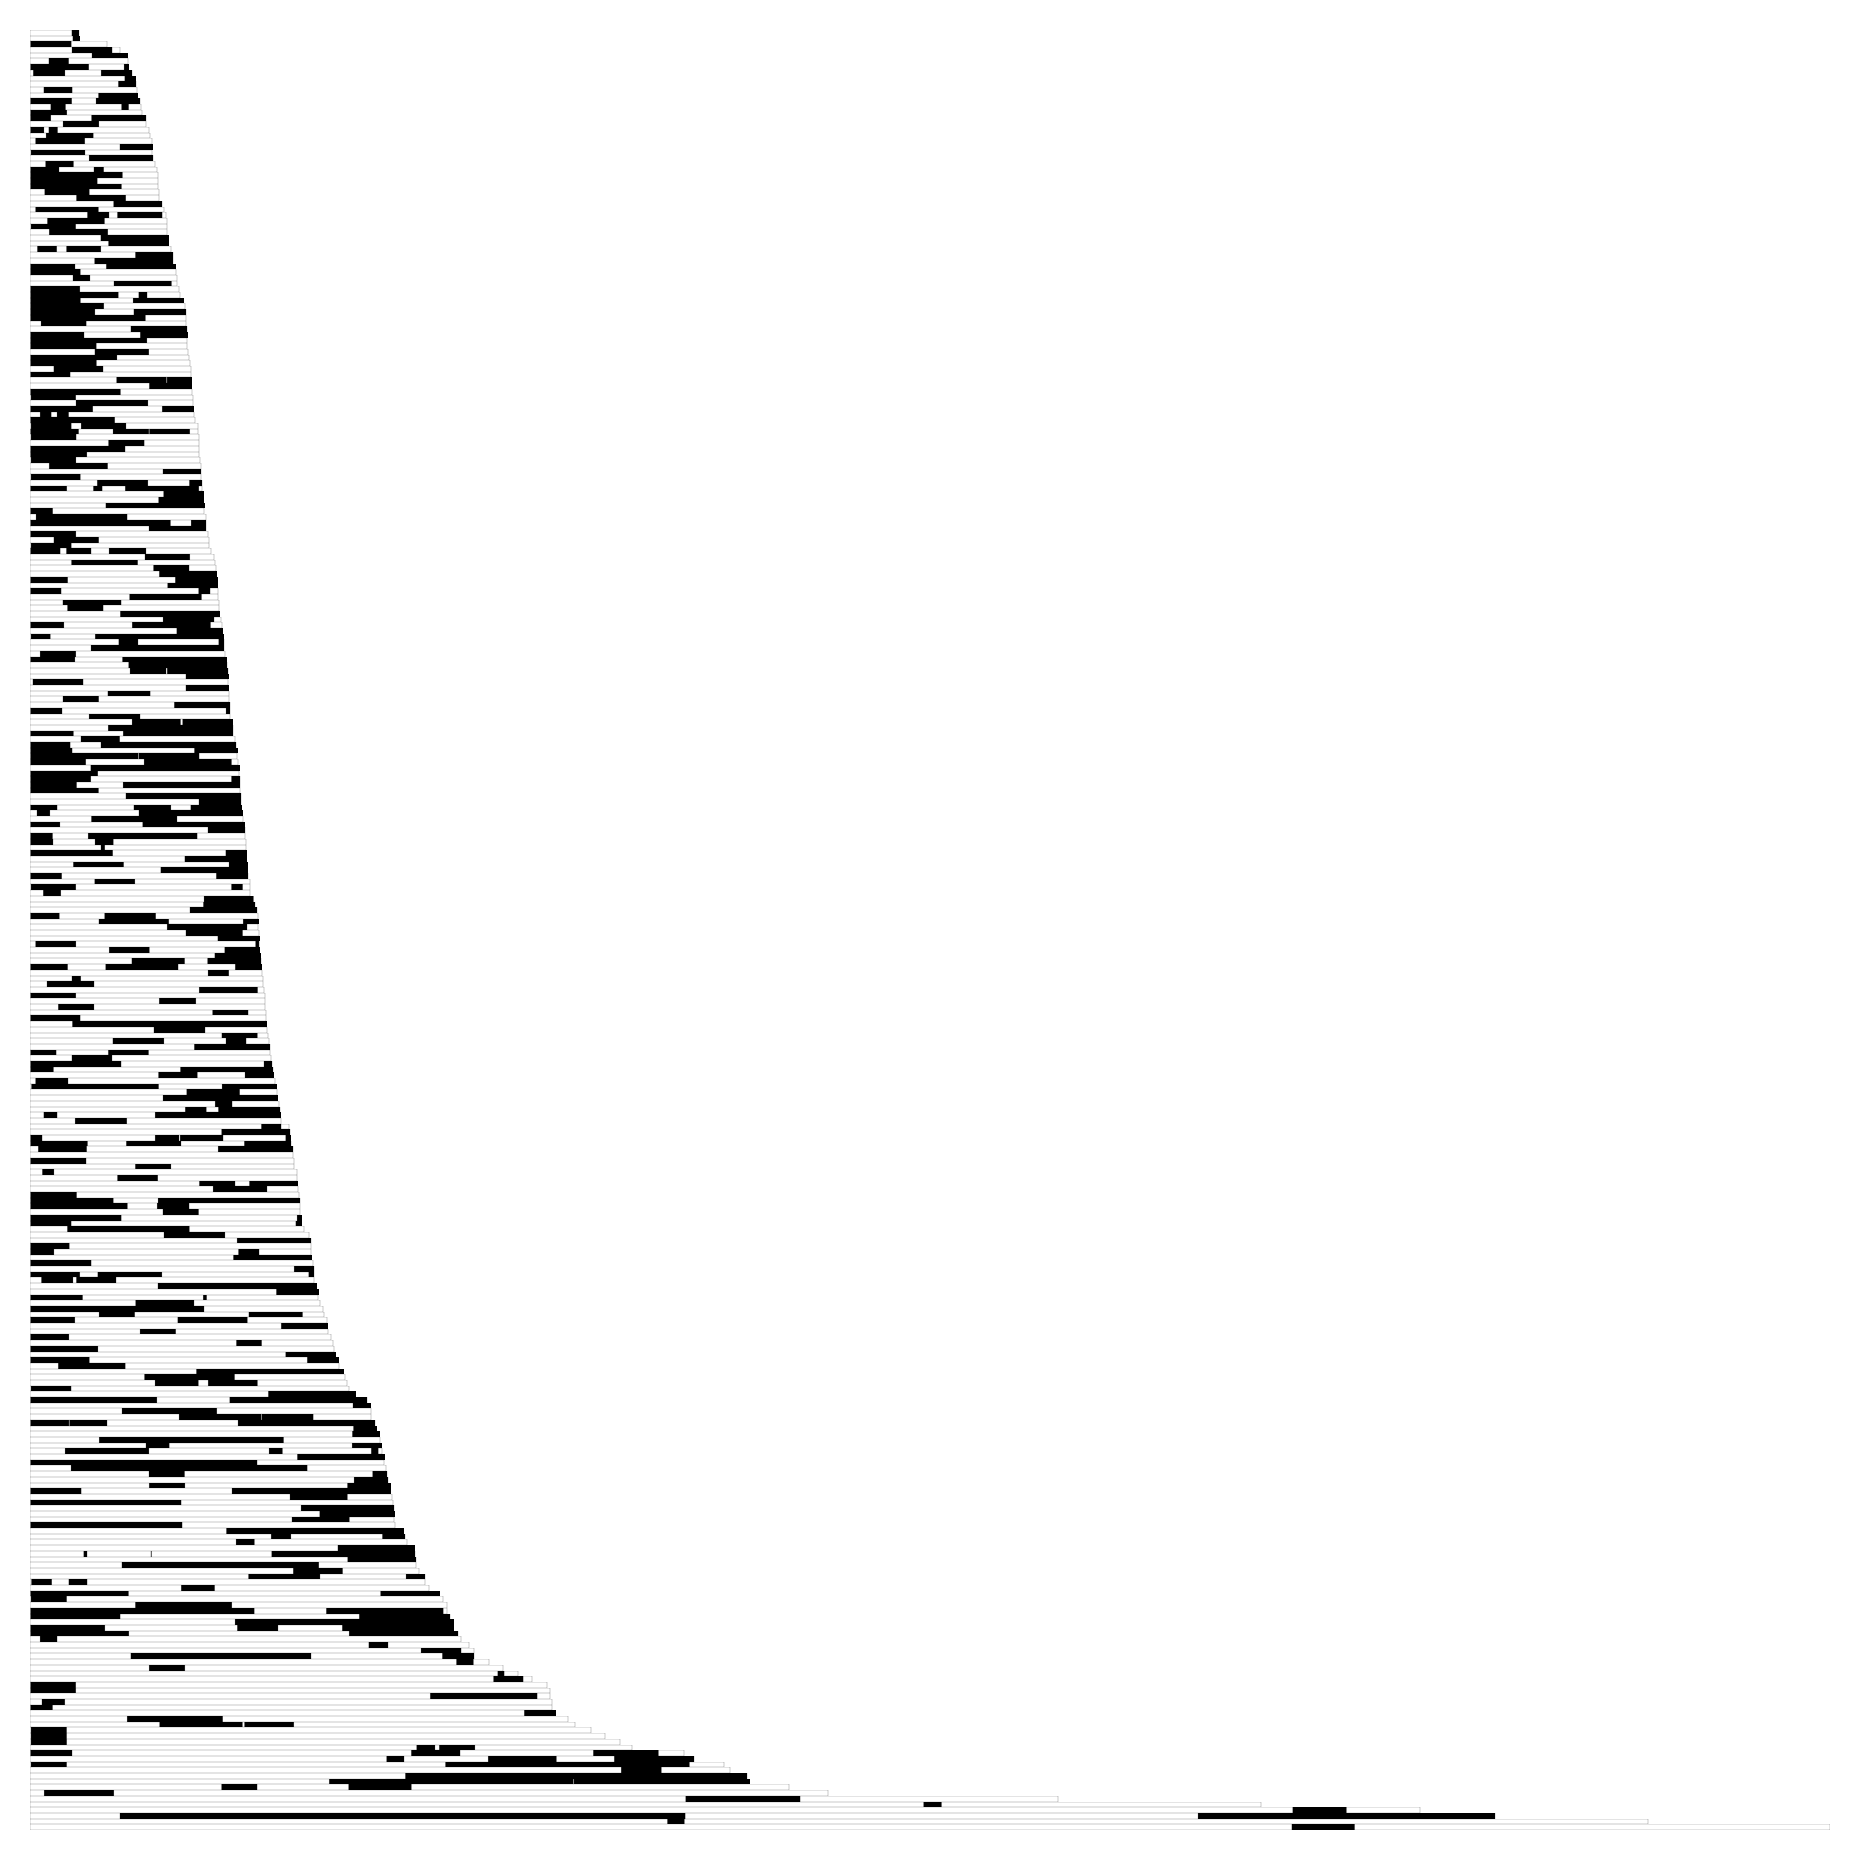

In [110]:
# Example DataFrame with a column of lists
# df = pd.DataFrame({
#     'data': [
#         [1, 2, 3],
#         [4, 5, 6],
#         [7, 8, 9]
#     ]
# })


# Extract the column of lists
data = acidic_activator_TF_preds['combined_annots'].tolist()

# # Find the maximum length of the lists
# max_len = max(len(row) for row in data)

# # Pad each list with np.nan (or 0) to make them all the same length
# padded_data = np.array([np.concatenate([row, [np.nan] * (max_len - len(row))]) for row in data])

fig,axs = plt.subplots(len(acidic_activator_TF_preds), 1, figsize = (6,6), sharex = True)
for i in range(len(axs)):
    ax = axs[i]
    # Use imshow to visualize
    axs[i].imshow(data[i][np.newaxis, :], cmap='Grays', aspect='auto', extent=[0, len(data[i]), 0, 1])  # or 'gray', 'hot', etc.
    axs[i].set_xlabel("")
    axs[i].set_xticks([])
    axs[i].set_yticks([])
    #a.colorbar()
    #plt.title('imshow of df column')
    #plt.show()

    rect = patches.Rectangle(
            (0, 0),  # (x, y) lower-left corner
            len(data[i]),
            1,  # height
            linewidth=0.05,
            edgecolor='black',
            facecolor='none'
        )
    ax.add_patch(rect)
    
sns.despine(left = True, bottom = True)
plt.tight_layout(pad = 0)

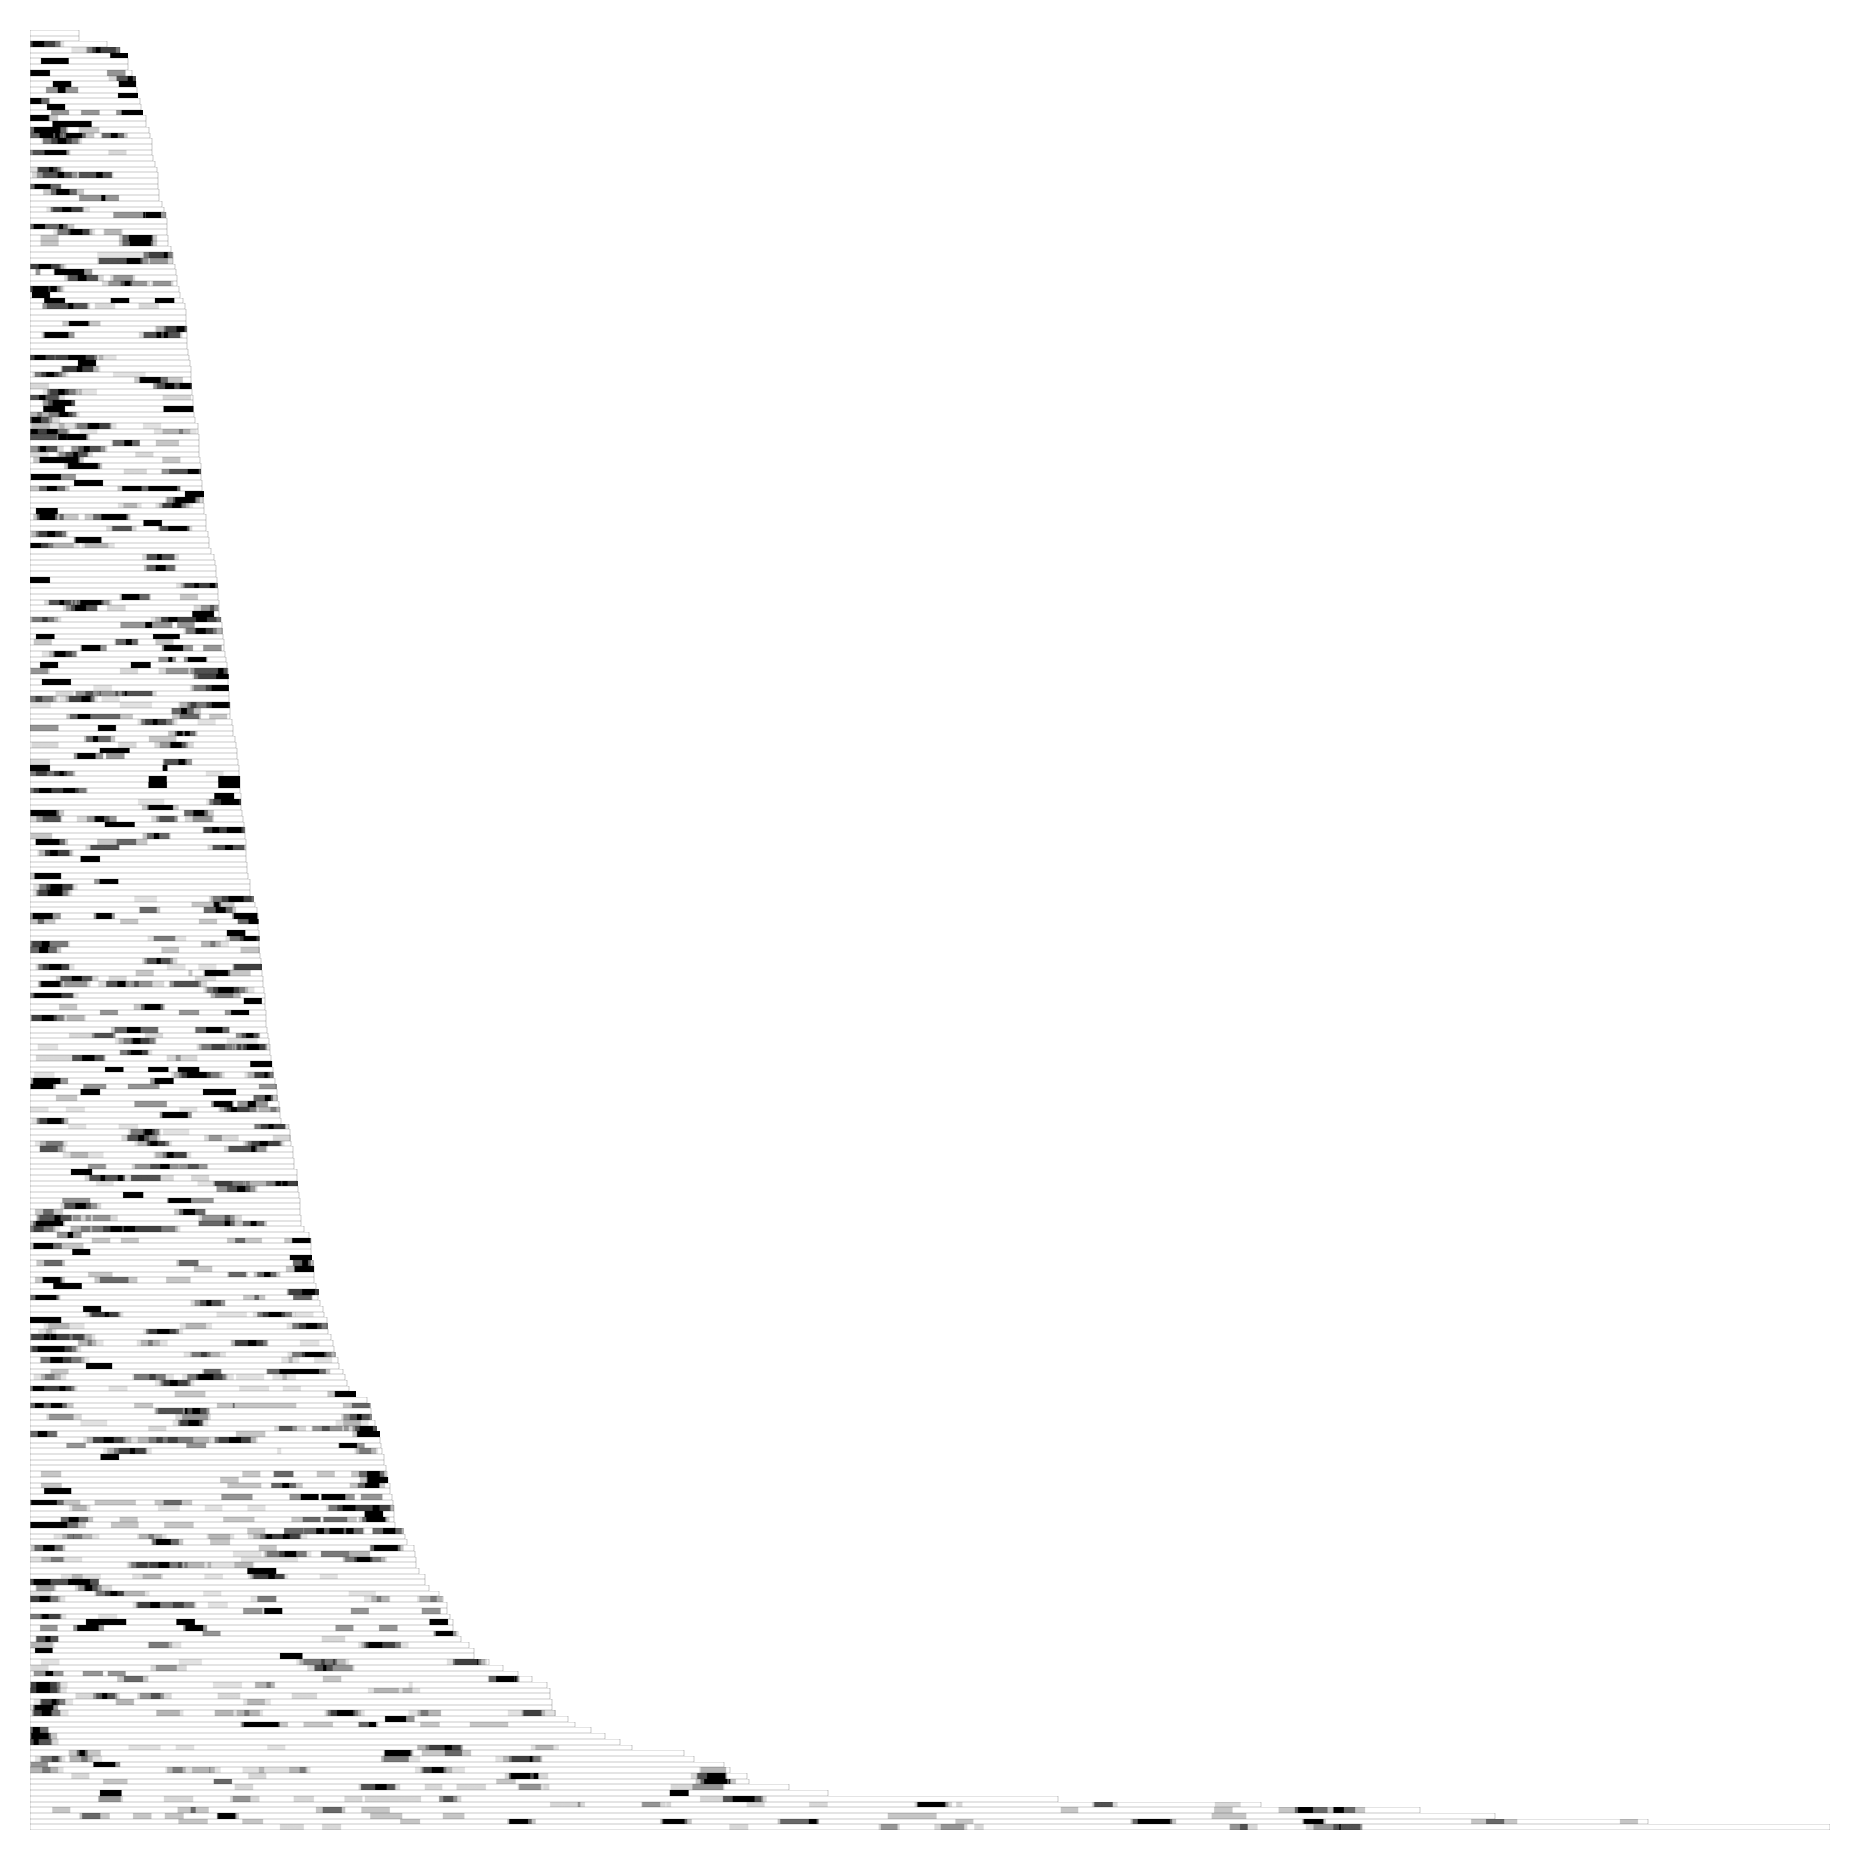

In [ ]:

# Example DataFrame with a column of lists
# df = pd.DataFrame({
#     'data': [
#         [1, 2, 3],
#         [4, 5, 6],
#         [7, 8, 9]
#     ]
# })


# Extract the column of lists
data = acidic_activator_TF_preds['combined_preds'].tolist()

# # Find the maximum length of the lists
# max_len = max(len(row) for row in data)

# # Pad each list with np.nan (or 0) to make them all the same length
# padded_data = np.array([np.concatenate([row, [np.nan] * (max_len - len(row))]) for row in data])

fig,axs = plt.subplots(len(acidic_activator_TF_preds), 1, figsize = (6,6), sharex = True)
for i in range(len(axs)):
    ax = axs[i]
    # Use imshow to visualize
    axs[i].imshow(data[i][np.newaxis, :], cmap='Grays', aspect='auto', extent=[0, len(data[i]), 0, 1])  # or 'gray', 'hot', etc.
    axs[i].set_xlabel("")
    axs[i].set_xticks([])
    axs[i].set_yticks([])
    #a.colorbar()
    #plt.title('imshow of df column')
    #plt.show()

    rect = patches.Rectangle(
            (0, 0),  # (x, y) lower-left corner
            len(data[i]),
            1,  # height
            linewidth=0.05,
            edgecolor='black',
            facecolor='none'
        )
    ax.add_patch(rect)
sns.despine(left = True, bottom = True)
plt.tight_layout(pad = 0)

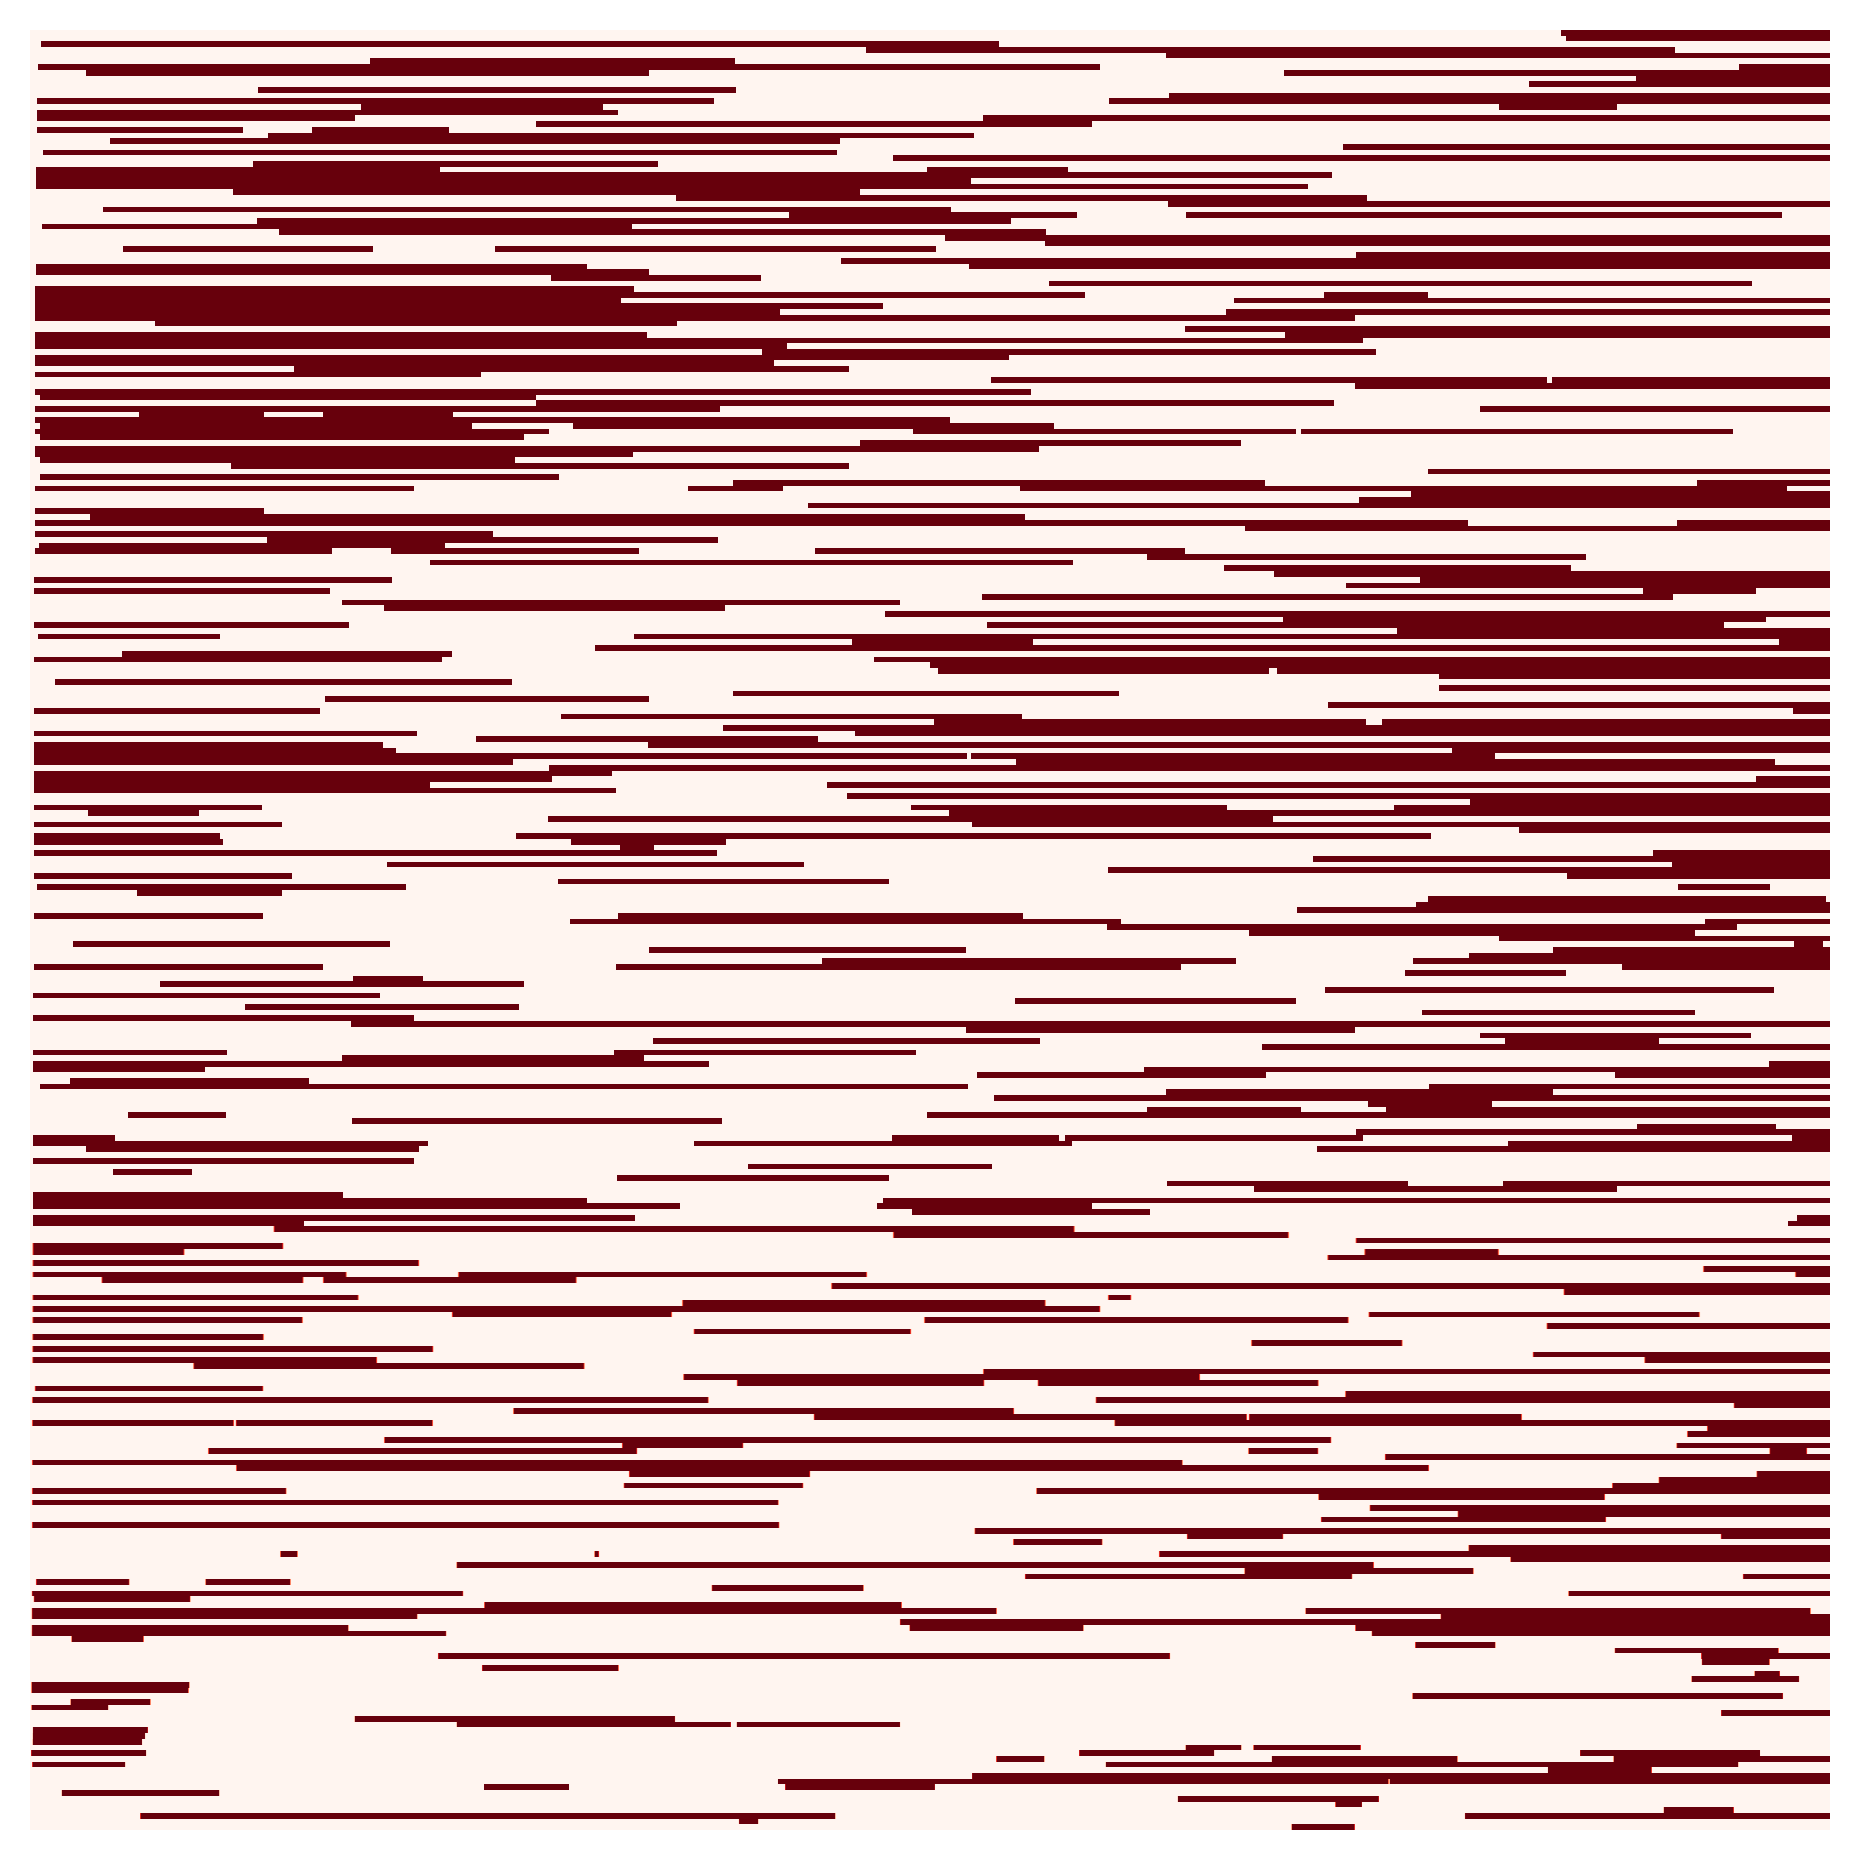

In [62]:
# Example DataFrame with a column of lists
# df = pd.DataFrame({
#     'data': [
#         [1, 2, 3],
#         [4, 5, 6],
#         [7, 8, 9]
#     ]
# })


# Extract the column of lists
data = acidic_activator_TF_preds['combined_annots'].tolist()

# # Find the maximum length of the lists
# max_len = max(len(row) for row in data)

# # Pad each list with np.nan (or 0) to make them all the same length
# padded_data = np.array([np.concatenate([row, [np.nan] * (max_len - len(row))]) for row in data])

fig,axs = plt.subplots(len(acidic_activator_TF_preds), 1, figsize = (6,6))
for i in range(len(axs)):
    ax = axs[i]
    # Use imshow to visualize
    axs[i].imshow(data[i][np.newaxis, :], cmap='Reds', aspect='auto', extent=[0, len(data[i]), 0, 1])  # or 'gray', 'hot', etc.
    axs[i].set_xlabel("")
    axs[i].set_xticks([])
    axs[i].set_yticks([])
    #a.colorbar()
    #plt.title('imshow of df column')
    #plt.show()

sns.despine(left = True, bottom = True)
plt.tight_layout(pad = 0)

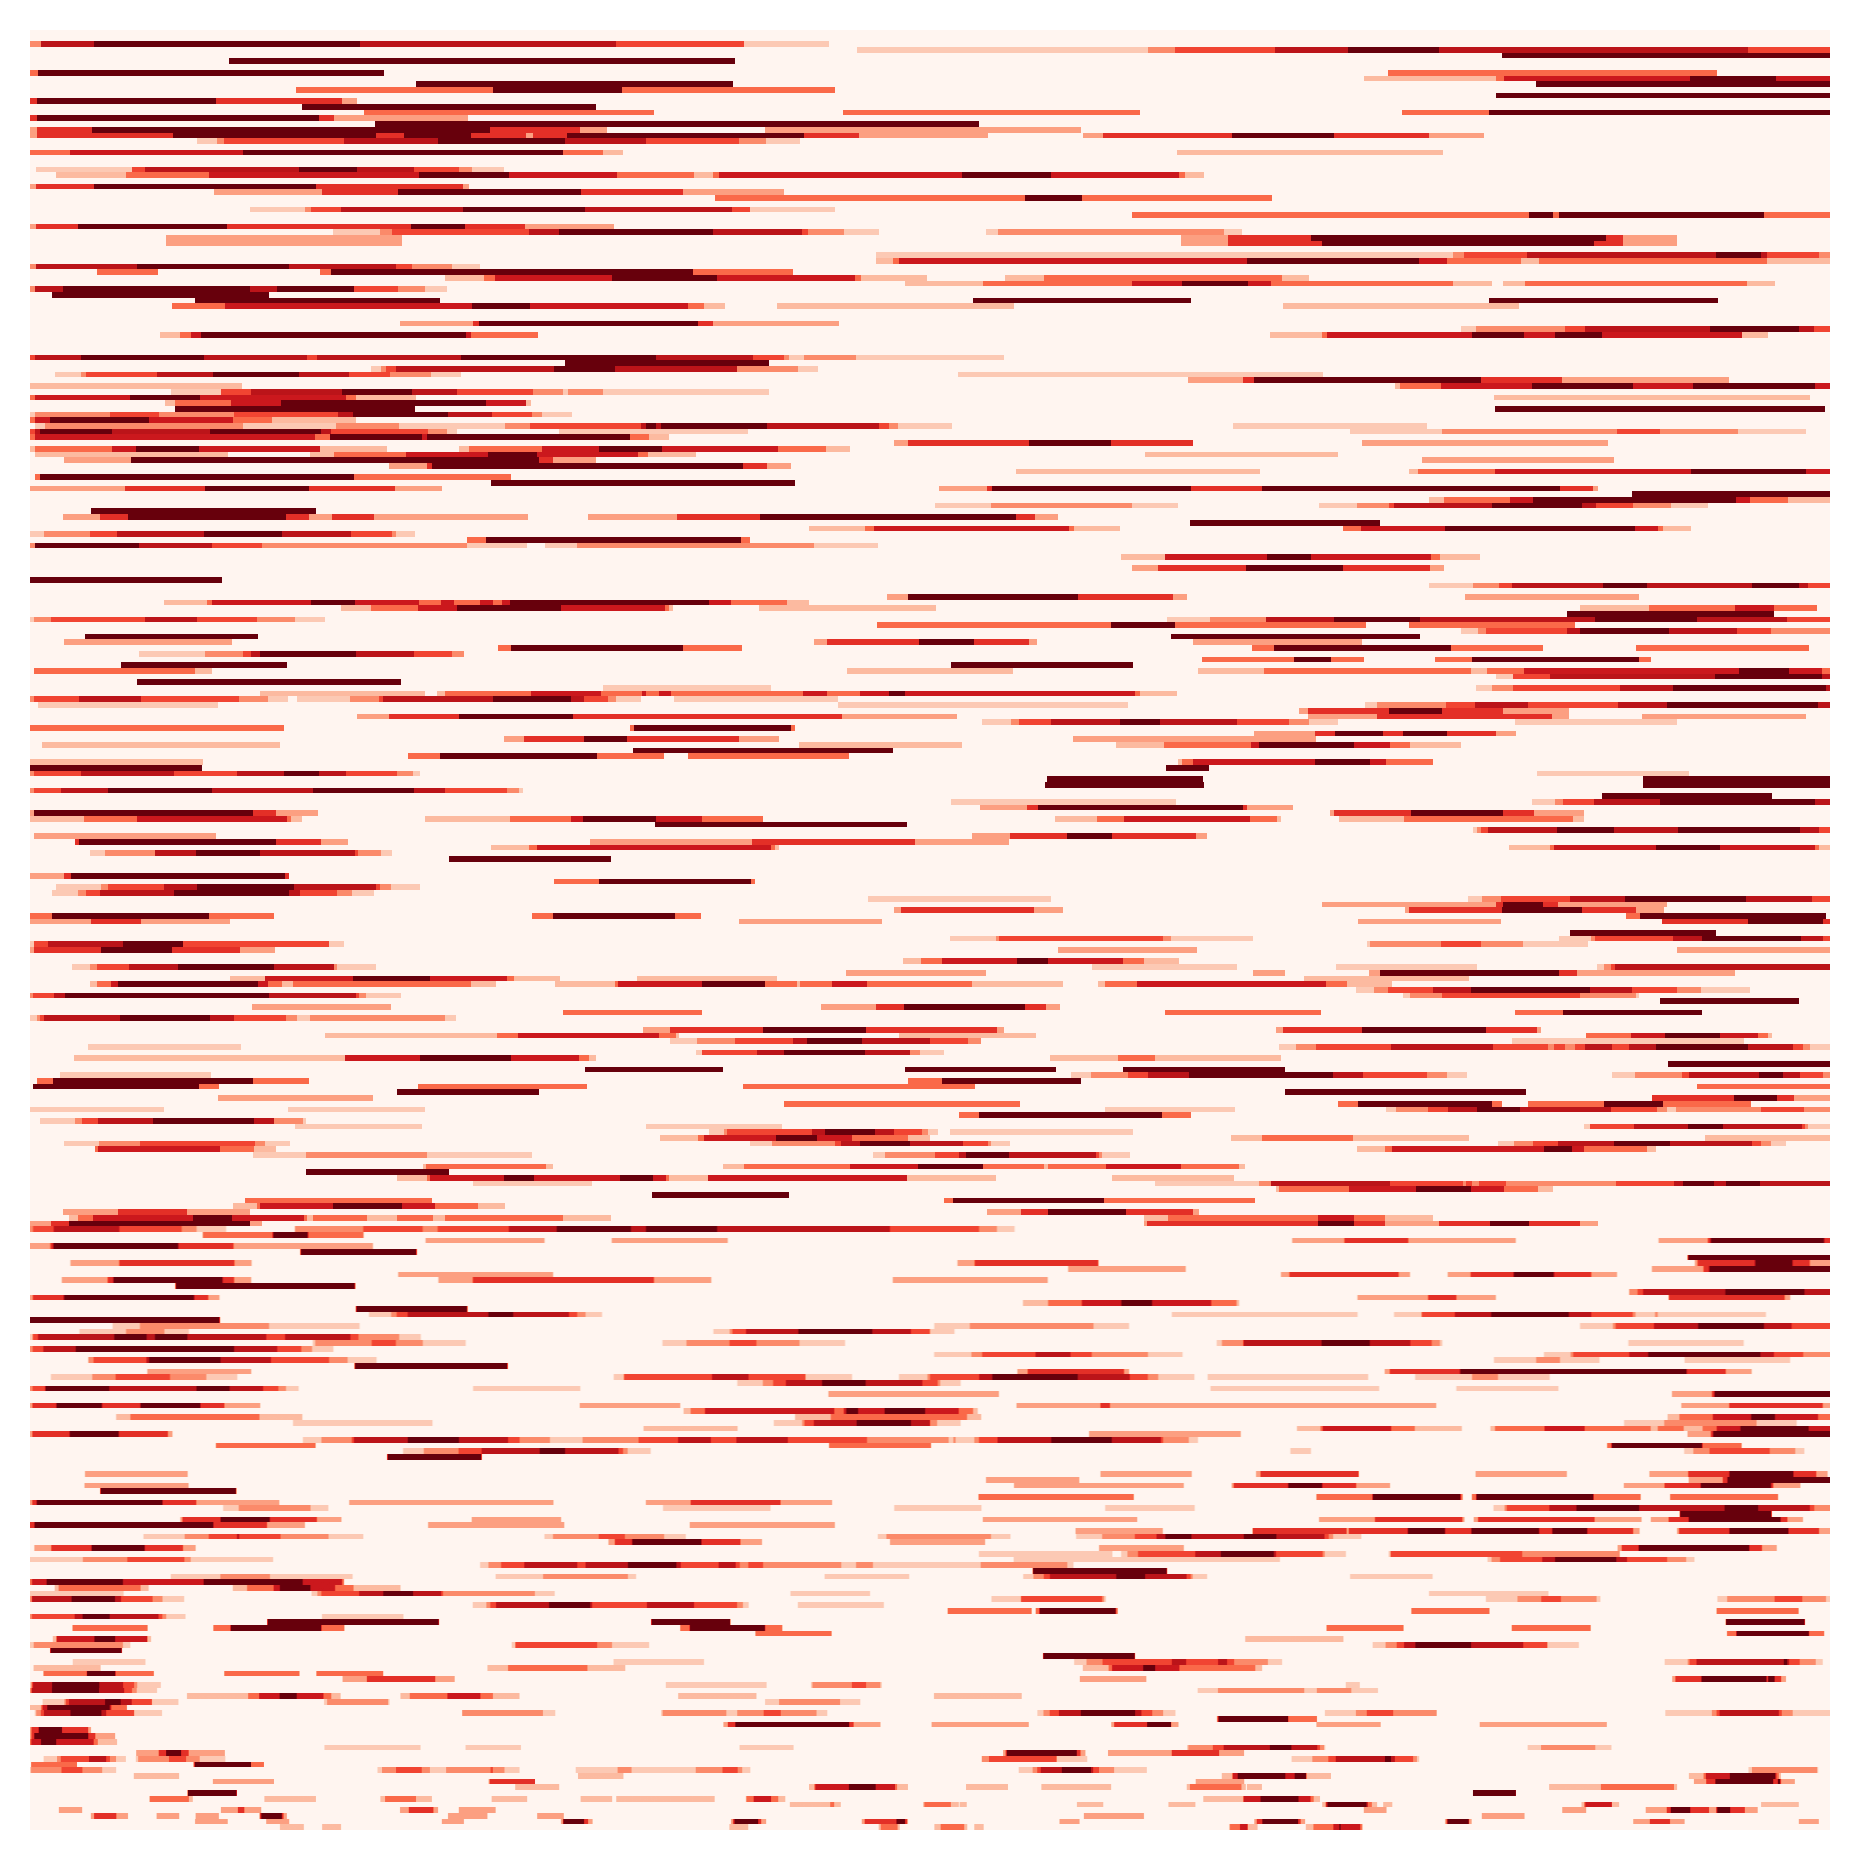

In [63]:
# Example DataFrame with a column of lists
# df = pd.DataFrame({
#     'data': [
#         [1, 2, 3],
#         [4, 5, 6],
#         [7, 8, 9]
#     ]
# })


# Extract the column of lists
data = acidic_activator_TF_preds['combined_preds'].tolist()

# # Find the maximum length of the lists
# max_len = max(len(row) for row in data)

# # Pad each list with np.nan (or 0) to make them all the same length
# padded_data = np.array([np.concatenate([row, [np.nan] * (max_len - len(row))]) for row in data])

fig,axs = plt.subplots(len(acidic_activator_TF_preds), 1, figsize = (6,6), sharex = False)
for i in range(len(axs)):
    ax = axs[i]
    # Use imshow to visualize
    axs[i].imshow(data[i][np.newaxis, :], cmap='Reds', aspect='auto', extent=[0, len(data[i]), 0, 1])  # or 'gray', 'hot', etc.
    axs[i].set_xlabel("")
    axs[i].set_xticks([])
    axs[i].set_yticks([])
    #a.colorbar()
    #plt.title('imshow of df column')
    #plt.show()

sns.despine(left = True, bottom = True)
plt.tight_layout(pad = 0)

In [19]:
lambert_TFs_with_preds["heatmap_locs"] = [np.arange(0, 1, 1/len(lambert_TFs_with_preds["combined_preds"].iloc[i] - 1)) for i in range(len(lambert_TFs_with_preds))]
lambert_TFs_with_preds

,uniprotID,sequence,combined_preds,heatmap_locs
0,P23511,MEQYTANSNSSTEQIVVQAGQIQQQQQGGVTAVQLQTEAQVASASG...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.002881844380403458, 0.0057636887608069..."
1,Q96QS3,MSNQYQEEGCSERPECKSKSPTLLSSYCIDSILGRRSPCKMRLLGA...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0017793594306049821, 0.003558718861209..."
2,P31270,MDFDERGPCSSNMYLPSCTYYVSGPDFSSLPSFLPQTPSSRPMTYS...,"[0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, ...","[0.0, 0.003194888178913738, 0.0063897763578274..."
3,P50221,MDPAASSCMRSLQPPAPVWGCLRNPHSEGNGASGLPHYPPTPFSFH...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.003937007874015748, 0.0078740157480314..."
4,P57073,MLDMSEARSQPPCSPSGTASSMSHVEDSDSDAPPSPAGSEGLGRAG...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.002242152466367713, 0.0044843049327354..."
...,...,...,...,...
1603,P35227,MHRTTRIKITELNPHLMCALCGGYFIDATTIVECLHSFCKTCIVRY...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0029069767441860465, 0.005813953488372..."
1604,Q9BS34,MDSVSFEDVAVAFTQEEWALLDPSQKNLYRDVMQEIFRNLASVGNK...,"[0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, ...","[0.0, 0.002570694087403599, 0.0051413881748071..."
1605,P17098,MDPEDEGVAGVMSVGPPAARLQEPVTFRDVAVDFTQEEWGQLDPTQ...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0017391304347826088, 0.003478260869565..."
1606,Q9UJW7,METLTSRHEKRALHSQASAISQDREEKIMSQEPLSFKDVAVVFTEE...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0012121212121212121, 0.002424242424242..."


In [27]:
lambert_TFs_with_preds["combined_preds_count"] = [len(preds) for preds in lambert_TFs_with_preds["combined_preds"]]
lambert_TFs_with_preds["heatmap_locs_count"] = [len(preds) for preds in lambert_TFs_with_preds["heatmap_locs"]]
lambert_TFs_with_preds

,uniprotID,sequence,combined_preds,heatmap_locs,combined_preds_count,heatmap_locs_count
0,P23511,MEQYTANSNSSTEQIVVQAGQIQQQQQGGVTAVQLQTEAQVASASG...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.002881844380403458, 0.0057636887608069...",347,347
1,Q96QS3,MSNQYQEEGCSERPECKSKSPTLLSSYCIDSILGRRSPCKMRLLGA...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0017793594306049821, 0.003558718861209...",562,562
2,P31270,MDFDERGPCSSNMYLPSCTYYVSGPDFSSLPSFLPQTPSSRPMTYS...,"[0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, ...","[0.0, 0.003194888178913738, 0.0063897763578274...",313,313
3,P50221,MDPAASSCMRSLQPPAPVWGCLRNPHSEGNGASGLPHYPPTPFSFH...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.003937007874015748, 0.0078740157480314...",254,254
4,P57073,MLDMSEARSQPPCSPSGTASSMSHVEDSDSDAPPSPAGSEGLGRAG...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.002242152466367713, 0.0044843049327354...",446,446
...,...,...,...,...,...,...
1603,P35227,MHRTTRIKITELNPHLMCALCGGYFIDATTIVECLHSFCKTCIVRY...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0029069767441860465, 0.005813953488372...",344,344
1604,Q9BS34,MDSVSFEDVAVAFTQEEWALLDPSQKNLYRDVMQEIFRNLASVGNK...,"[0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, ...","[0.0, 0.002570694087403599, 0.0051413881748071...",389,389
1605,P17098,MDPEDEGVAGVMSVGPPAARLQEPVTFRDVAVDFTQEEWGQLDPTQ...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0017391304347826088, 0.003478260869565...",575,575
1606,Q9UJW7,METLTSRHEKRALHSQASAISQDREEKIMSQEPLSFKDVAVVFTEE...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0012121212121212121, 0.002424242424242...",825,825


In [31]:
lambert_TFs_with_preds[lambert_TFs_with_preds["combined_preds_count"] != lambert_TFs_with_preds["heatmap_locs_count"]]

,uniprotID,sequence,combined_preds,heatmap_locs,combined_preds_count,heatmap_locs_count
21,O43670,MGRKKKKQLKPWCWYCNRDFDDEKILIQHQKAKHFKCHICHKKLYT...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0020920502092050207, 0.004184100418410...",478,479
37,Q9BVI0,MTKHPPNRRGISFEVGAQLEARDRLKNWYPAHIEDIDYEEGKVLIH...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0009881422924901185, 0.001976284584980...",1012,1013
39,P09086,MVHSSMGAPEIRMSKPLEAEKQGLDSPSEHTDTERNGPDTNHQNPQ...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0020876826722338203, 0.004175365344467...",479,480
44,Q8WTV1,MPKSCAARQCCNRYSSRRKQLTFHRFPFSRPELLKEWVLNIGRGNF...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0041841004184100415, 0.008368200836820...",239,240
53,Q8ND82,MDDDKPFQPKNISKMAELFMECEEEELEPWQKKVEETQDEDDDELI...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2, 0.2, ...","[0.0, 0.0013568521031207597, 0.002713704206241...",737,738
...,...,...,...,...,...,...
1558,Q3ZCT1,MIGMLESLQHESDLLQHDQIHTGEKPYECNECRKTFSLKQNLVEHK...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0024271844660194173, 0.004854368932038...",412,413
1566,O75346,MGPLQFRDVAIEFSLEEWHCLDTAQRNLYRDVMLENYRNLVFLGIV...,"[0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.4, 0.4, 0.4, ...","[0.0, 0.002004008016032064, 0.0040080160320641...",499,500
1580,P78347,MAQVAMSTLPVEDEESSESRMVVTFLMSALESMCKELAKSKAEVAC...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.001002004008016032, 0.0020040080160320...",998,999
1595,Q3SYB3,MNLPRAERLRSTPQRSLRDSDGEDGKIDVLGEEEDEDEVEDEEEAA...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.002398081534772182, 0.0047961630695443...",417,418


In [28]:
len(lambert_TFs_with_preds["heatmap_locs"].iloc[1])

562

In [29]:
len(lambert_TFs_with_preds["combined_preds"].iloc[1])

562

In [30]:
lambert_TFs_with_preds.explode(["combined_preds", "heatmap_locs"])

ValueError: columns must have matching element counts

,Gene,Start,End,uniprotID,Matching Isoforms,Canonical Transcript ID,orig_uniprotID,Reference,TileType,ProteinRegionSeq,Notes
1,AEBP1,1088,1158,Q8IUX7,[['Q8IUX7']],NaN,Q8IUX7,Staller Activity Data,TF,EVVTEFGTEVEPEFGTKVEPEFETQLEPEFETQLEPEFEEEEEEEK...,NaN
2,AHCTF1,1445,1698,Q8WYP5,"[['Q8WYP5'], ['Q8WYP5']]",nan / nan,Q8WYP5 / Q8WYP5,"PMID: 11952839, Soto / transcriptionalactivity...",TF,IRANDNKSMADVLGDGGNSSLTISEGPIVSERRLNQEVALNLKEDH...,NaN
3,AHR,118,126,P35869,[['P35869']],NaN,P35869,"transcriptionalactivity_regions.txt, GSL",TF,LLQALNGFV,NaN
4,AHR,266,268,P35869,[['P35869']],NaN,P35869,"transcriptionalactivity_regions.txt, GSL",TF,FAI,NaN
5,AHR,532,848,P35869,"[['P35869'], ['P35869'], ['P35869']]",ENST00000242057 / nan / ENST00000242057,P35869 / P35869 / P35869,"DelRosso et al. / PMID: 8794892, Soto / DelRos...",TF,QDSKNSDLYSIMKNLGIDFEDIRHMQNEKFFRNDFSGEVDFRDIDL...,NaN
...,...,...,...,...,...,...,...,...,...,...,...
755,ZXDB,576,703,P98169,[['P98169']],NaN,P98169 / P98169,"R4TA_regions.txt / activation_regions.txt, GSL",TF,QDLLAQLEAANSLTPSSELTSQRQNDLSDAEIVSLFSDVPDSTSAA...,NaN
756,ZXDC,579,688,Q2QGD7,"[['Q2QGD7', 'Q2QGD7-2'], ['Q2QGD7', 'Q2QGD7-2']]",nan / nan,Q2QGD7 / Q2QGD7 / Q2QGD7,"PMID: 16600381, Soto / R4TA_regions.txt / acti...",TF,DSPLVLGTAATVLQQGSFSVDDVQTVSAGALGCLVALPMKNLSDDP...,NaN
757,c-ETS1,175,286,P14921-3,[['P14921-3']],NaN,P14921,"Choi 2000 list, GSL",TF,ILQKEDVKPYQVNGVNPAYPESRYTSDYFISYGIEHAQCVPPSEFS...,NaN
758,c-Jun/AP-1,238,257,P05412,[['P05412']],NaN,P05412,"Choi 2000 list, GSL",TF,ETPPLSPIDMESQERIKAER,NaN


# Count table

Goal: For each known acidic AD, how many predictors detect it?

In [82]:
def count_overlaps(row, df2):
    # Filter df2 by matching uniprotID
    matching_rows = df2[df2['uniprotID'] == row['uniprotID']]
    
    # Count overlaps: intervals overlap if
    # start1 < end2 AND end1 > start2
    overlaps = matching_rows[((matching_rows['Start'] < row['End']) & (matching_rows['End'] > row['Start']))]
    
    return len(overlaps["predictor"].unique())


In [83]:
known_ADs

,Gene,Start,End,uniprotID,Matching Isoforms,Canonical Transcript ID,orig_uniprotID,Reference,TileType,ProteinRegionSeq,Notes,charge,overlap_count,pred_overlap_count
1,AEBP1,1088,1158,Q8IUX7,[['Q8IUX7']],NaN,Q8IUX7,Staller Activity Data,TF,EVVTEFGTEVEPEFGTKVEPEFETQLEPEFETQLEPEFEEEEEEEK...,NaN,-23,4,4
2,AHCTF1,1445,1698,Q8WYP5,"[['Q8WYP5'], ['Q8WYP5']]",nan / nan,Q8WYP5 / Q8WYP5,"PMID: 11952839, Soto / transcriptionalactivity...",TF,IRANDNKSMADVLGDGGNSSLTISEGPIVSERRLNQEVALNLKEDH...,NaN,-36,4,4
3,AHR,118,126,P35869,[['P35869']],NaN,P35869,"transcriptionalactivity_regions.txt, GSL",TF,LLQALNGFV,NaN,0,0,0
4,AHR,266,268,P35869,[['P35869']],NaN,P35869,"transcriptionalactivity_regions.txt, GSL",TF,FAI,NaN,0,0,0
5,AHR,532,848,P35869,"[['P35869'], ['P35869'], ['P35869']]",ENST00000242057 / nan / ENST00000242057,P35869 / P35869 / P35869,"DelRosso et al. / PMID: 8794892, Soto / DelRos...",TF,QDSKNSDLYSIMKNLGIDFEDIRHMQNEKFFRNDFSGEVDFRDIDL...,NaN,-20,8,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
755,ZXDB,576,703,P98169,[['P98169']],NaN,P98169 / P98169,"R4TA_regions.txt / activation_regions.txt, GSL",TF,QDLLAQLEAANSLTPSSELTSQRQNDLSDAEIVSLFSDVPDSTSAA...,NaN,-14,4,4
756,ZXDC,579,688,Q2QGD7,"[['Q2QGD7', 'Q2QGD7-2'], ['Q2QGD7', 'Q2QGD7-2']]",nan / nan,Q2QGD7 / Q2QGD7 / Q2QGD7,"PMID: 16600381, Soto / R4TA_regions.txt / acti...",TF,DSPLVLGTAATVLQQGSFSVDDVQTVSAGALGCLVALPMKNLSDDP...,NaN,-6,0,0
757,c-ETS1,175,286,P14921-3,[['P14921-3']],NaN,P14921,"Choi 2000 list, GSL",TF,ILQKEDVKPYQVNGVNPAYPESRYTSDYFISYGIEHAQCVPPSEFS...,NaN,-10,0,0
758,c-Jun/AP-1,238,257,P05412,[['P05412']],NaN,P05412,"Choi 2000 list, GSL",TF,ETPPLSPIDMESQERIKAER,NaN,-2,0,0


In [84]:
known_ADs['pred_overlap_count'] = known_ADs.apply(count_overlaps, axis=1, df2=all_models)
known_ADs

,Gene,Start,End,uniprotID,Matching Isoforms,Canonical Transcript ID,orig_uniprotID,Reference,TileType,ProteinRegionSeq,Notes,charge,overlap_count,pred_overlap_count
1,AEBP1,1088,1158,Q8IUX7,[['Q8IUX7']],NaN,Q8IUX7,Staller Activity Data,TF,EVVTEFGTEVEPEFGTKVEPEFETQLEPEFETQLEPEFEEEEEEEK...,NaN,-23,4,4
2,AHCTF1,1445,1698,Q8WYP5,"[['Q8WYP5'], ['Q8WYP5']]",nan / nan,Q8WYP5 / Q8WYP5,"PMID: 11952839, Soto / transcriptionalactivity...",TF,IRANDNKSMADVLGDGGNSSLTISEGPIVSERRLNQEVALNLKEDH...,NaN,-36,4,4
3,AHR,118,126,P35869,[['P35869']],NaN,P35869,"transcriptionalactivity_regions.txt, GSL",TF,LLQALNGFV,NaN,0,0,0
4,AHR,266,268,P35869,[['P35869']],NaN,P35869,"transcriptionalactivity_regions.txt, GSL",TF,FAI,NaN,0,0,0
5,AHR,532,848,P35869,"[['P35869'], ['P35869'], ['P35869']]",ENST00000242057 / nan / ENST00000242057,P35869 / P35869 / P35869,"DelRosso et al. / PMID: 8794892, Soto / DelRos...",TF,QDSKNSDLYSIMKNLGIDFEDIRHMQNEKFFRNDFSGEVDFRDIDL...,NaN,-20,8,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
755,ZXDB,576,703,P98169,[['P98169']],NaN,P98169 / P98169,"R4TA_regions.txt / activation_regions.txt, GSL",TF,QDLLAQLEAANSLTPSSELTSQRQNDLSDAEIVSLFSDVPDSTSAA...,NaN,-14,4,3
756,ZXDC,579,688,Q2QGD7,"[['Q2QGD7', 'Q2QGD7-2'], ['Q2QGD7', 'Q2QGD7-2']]",nan / nan,Q2QGD7 / Q2QGD7 / Q2QGD7,"PMID: 16600381, Soto / R4TA_regions.txt / acti...",TF,DSPLVLGTAATVLQQGSFSVDDVQTVSAGALGCLVALPMKNLSDDP...,NaN,-6,0,0
757,c-ETS1,175,286,P14921-3,[['P14921-3']],NaN,P14921,"Choi 2000 list, GSL",TF,ILQKEDVKPYQVNGVNPAYPESRYTSDYFISYGIEHAQCVPPSEFS...,NaN,-10,0,0
758,c-Jun/AP-1,238,257,P05412,[['P05412']],NaN,P05412,"Choi 2000 list, GSL",TF,ETPPLSPIDMESQERIKAER,NaN,-2,0,0


In [98]:
acidic_known_ADs['pred_overlap_count'] = acidic_known_ADs.apply(count_overlaps, axis=1, df2=all_models)
acidic_known_ADs

,Gene,Start,End,uniprotID,Matching Isoforms,Canonical Transcript ID,orig_uniprotID,Reference,TileType,ProteinRegionSeq,Notes,charge,pred_overlap_count
1,AEBP1,1088,1158,Q8IUX7,[['Q8IUX7']],NaN,Q8IUX7,Staller Activity Data,TF,EVVTEFGTEVEPEFGTKVEPEFETQLEPEFETQLEPEFEEEEEEEK...,NaN,-23,4
2,AHCTF1,1445,1698,Q8WYP5,"[['Q8WYP5'], ['Q8WYP5']]",nan / nan,Q8WYP5 / Q8WYP5,"PMID: 11952839, Soto / transcriptionalactivity...",TF,IRANDNKSMADVLGDGGNSSLTISEGPIVSERRLNQEVALNLKEDH...,NaN,-36,4
5,AHR,532,848,P35869,"[['P35869'], ['P35869'], ['P35869']]",ENST00000242057 / nan / ENST00000242057,P35869 / P35869 / P35869,"DelRosso et al. / PMID: 8794892, Soto / DelRos...",TF,QDSKNSDLYSIMKNLGIDFEDIRHMQNEKFFRNDFSGEVDFRDIDL...,NaN,-20,5
6,AIRE,292,545,O43918,[['O43918']],NaN,O43918,"PMID: 11274163, Soto",TF,HQKNEDECAVCRDGGELICCDGCPRAFHLACLSPPLREIPSGTWRC...,NaN,-10,3
8,AKAP8L,1,384,Q9ULX6,"[['Q9ULX6'], ['Q9ULX6'], ['Q9ULX6']]",nan / nan / ENST00000397410,Q9ULX6 / Q9ULX6 / Q9ULX6,"PMID: 11402034, Soto / activation_regions.txt,...",TF,MSYTGFVQGSETTLQSTYSDTSAQPTCDYGYGTWNSGTNRGYEGYG...,NaN,-13,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
754,ZXDA,572,699,P98168,"[['P98168'], ['P98168']]",nan / nan,P98168 / P98168 / P98168,"PMID: 17493635, Soto / R4TA_regions.txt / acti...",TF,QDLLAQLEAANSLTPSSELTSQRQNDLSDAEIVSLFSDVPDSTSAA...,NaN,-14,3
755,ZXDB,576,703,P98169,[['P98169']],NaN,P98169 / P98169,"R4TA_regions.txt / activation_regions.txt, GSL",TF,QDLLAQLEAANSLTPSSELTSQRQNDLSDAEIVSLFSDVPDSTSAA...,NaN,-14,3
756,ZXDC,579,688,Q2QGD7,"[['Q2QGD7', 'Q2QGD7-2'], ['Q2QGD7', 'Q2QGD7-2']]",nan / nan,Q2QGD7 / Q2QGD7 / Q2QGD7,"PMID: 16600381, Soto / R4TA_regions.txt / acti...",TF,DSPLVLGTAATVLQQGSFSVDDVQTVSAGALGCLVALPMKNLSDDP...,NaN,-6,0
757,c-ETS1,175,286,P14921-3,[['P14921-3']],NaN,P14921,"Choi 2000 list, GSL",TF,ILQKEDVKPYQVNGVNPAYPESRYTSDYFISYGIEHAQCVPPSEFS...,NaN,-10,0


In [89]:
min(known_ADs["pred_overlap_count"])

0

In [87]:
max(known_ADs["pred_overlap_count"])

5

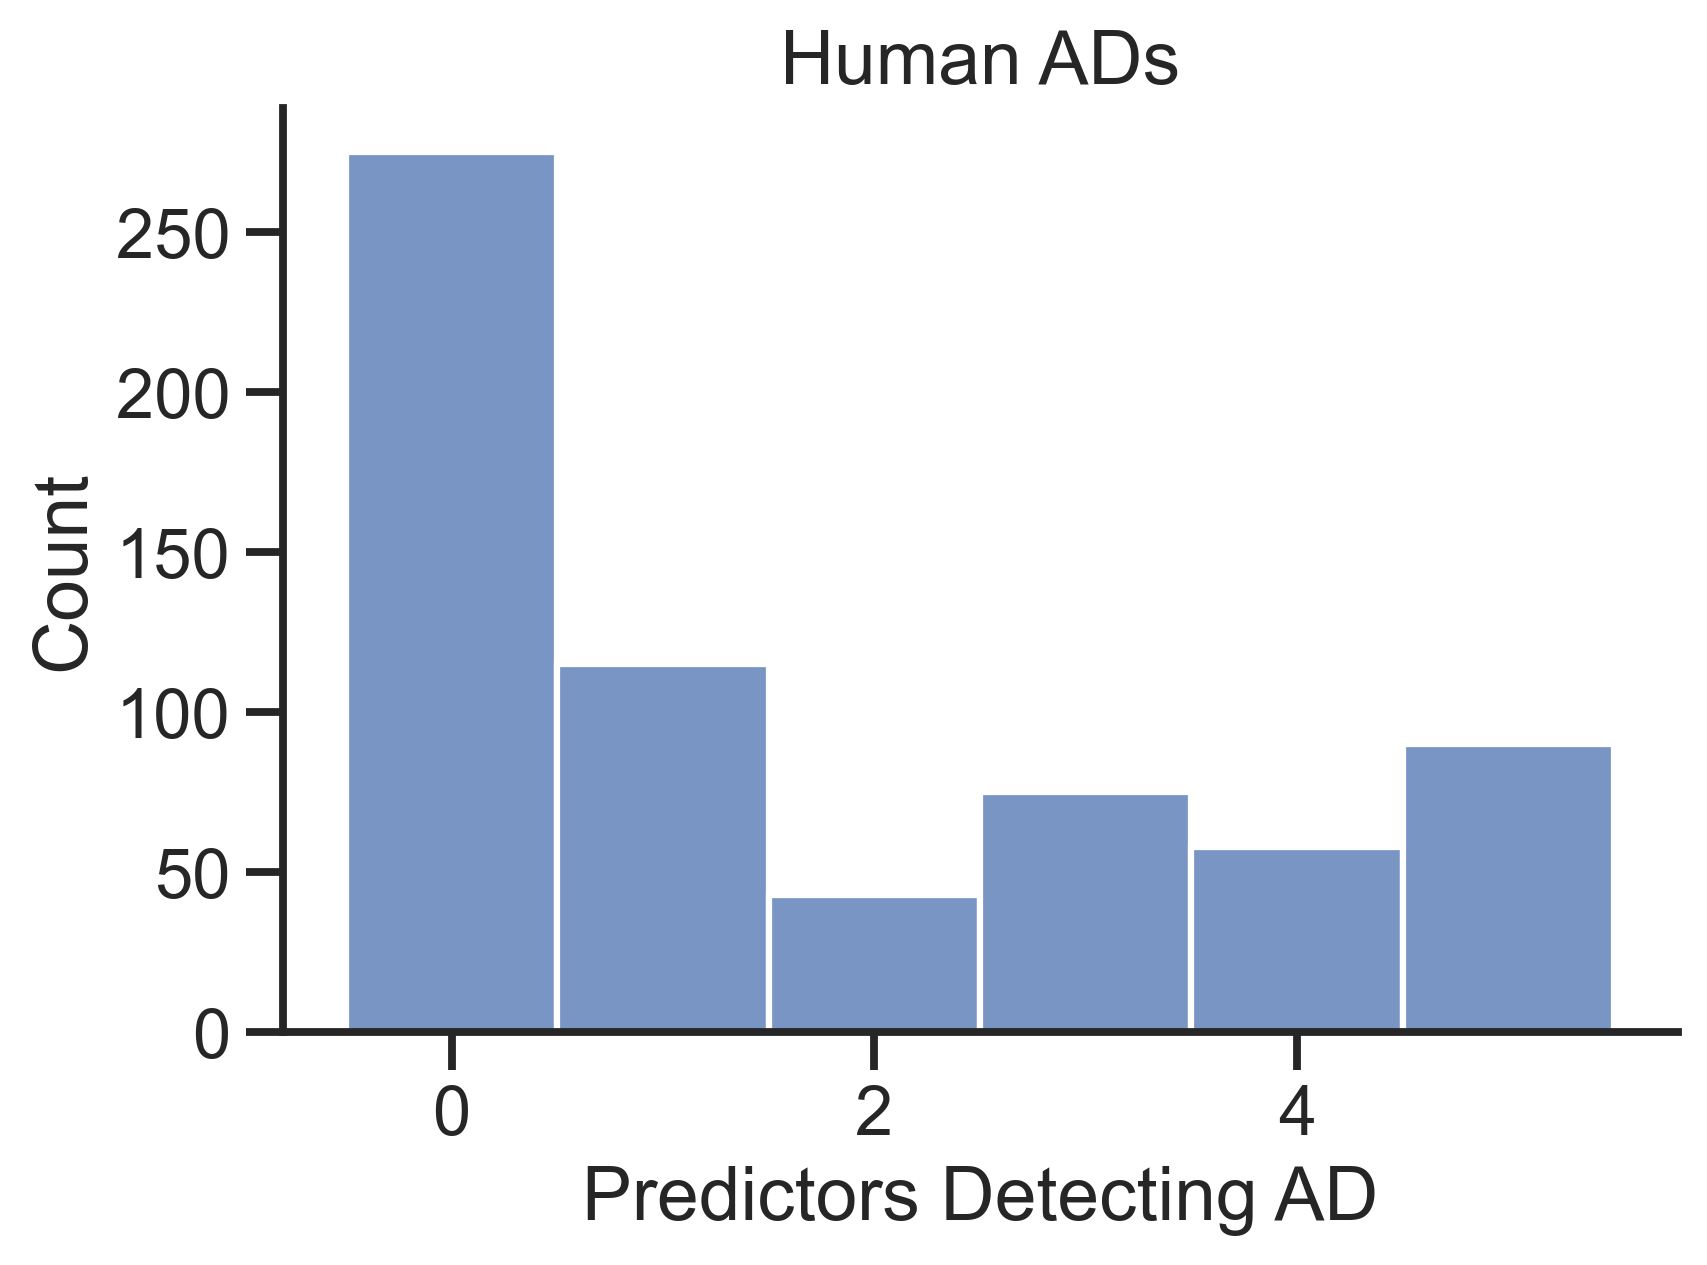

In [99]:
sns.set_context('talk')
sns.set_style('ticks')
sns.histplot(known_ADs["pred_overlap_count"], bins = np.arange(-0.5, 6.5,1))
plt.xlabel("Predictors Detecting AD")
plt.title("Human ADs")
sns.despine()

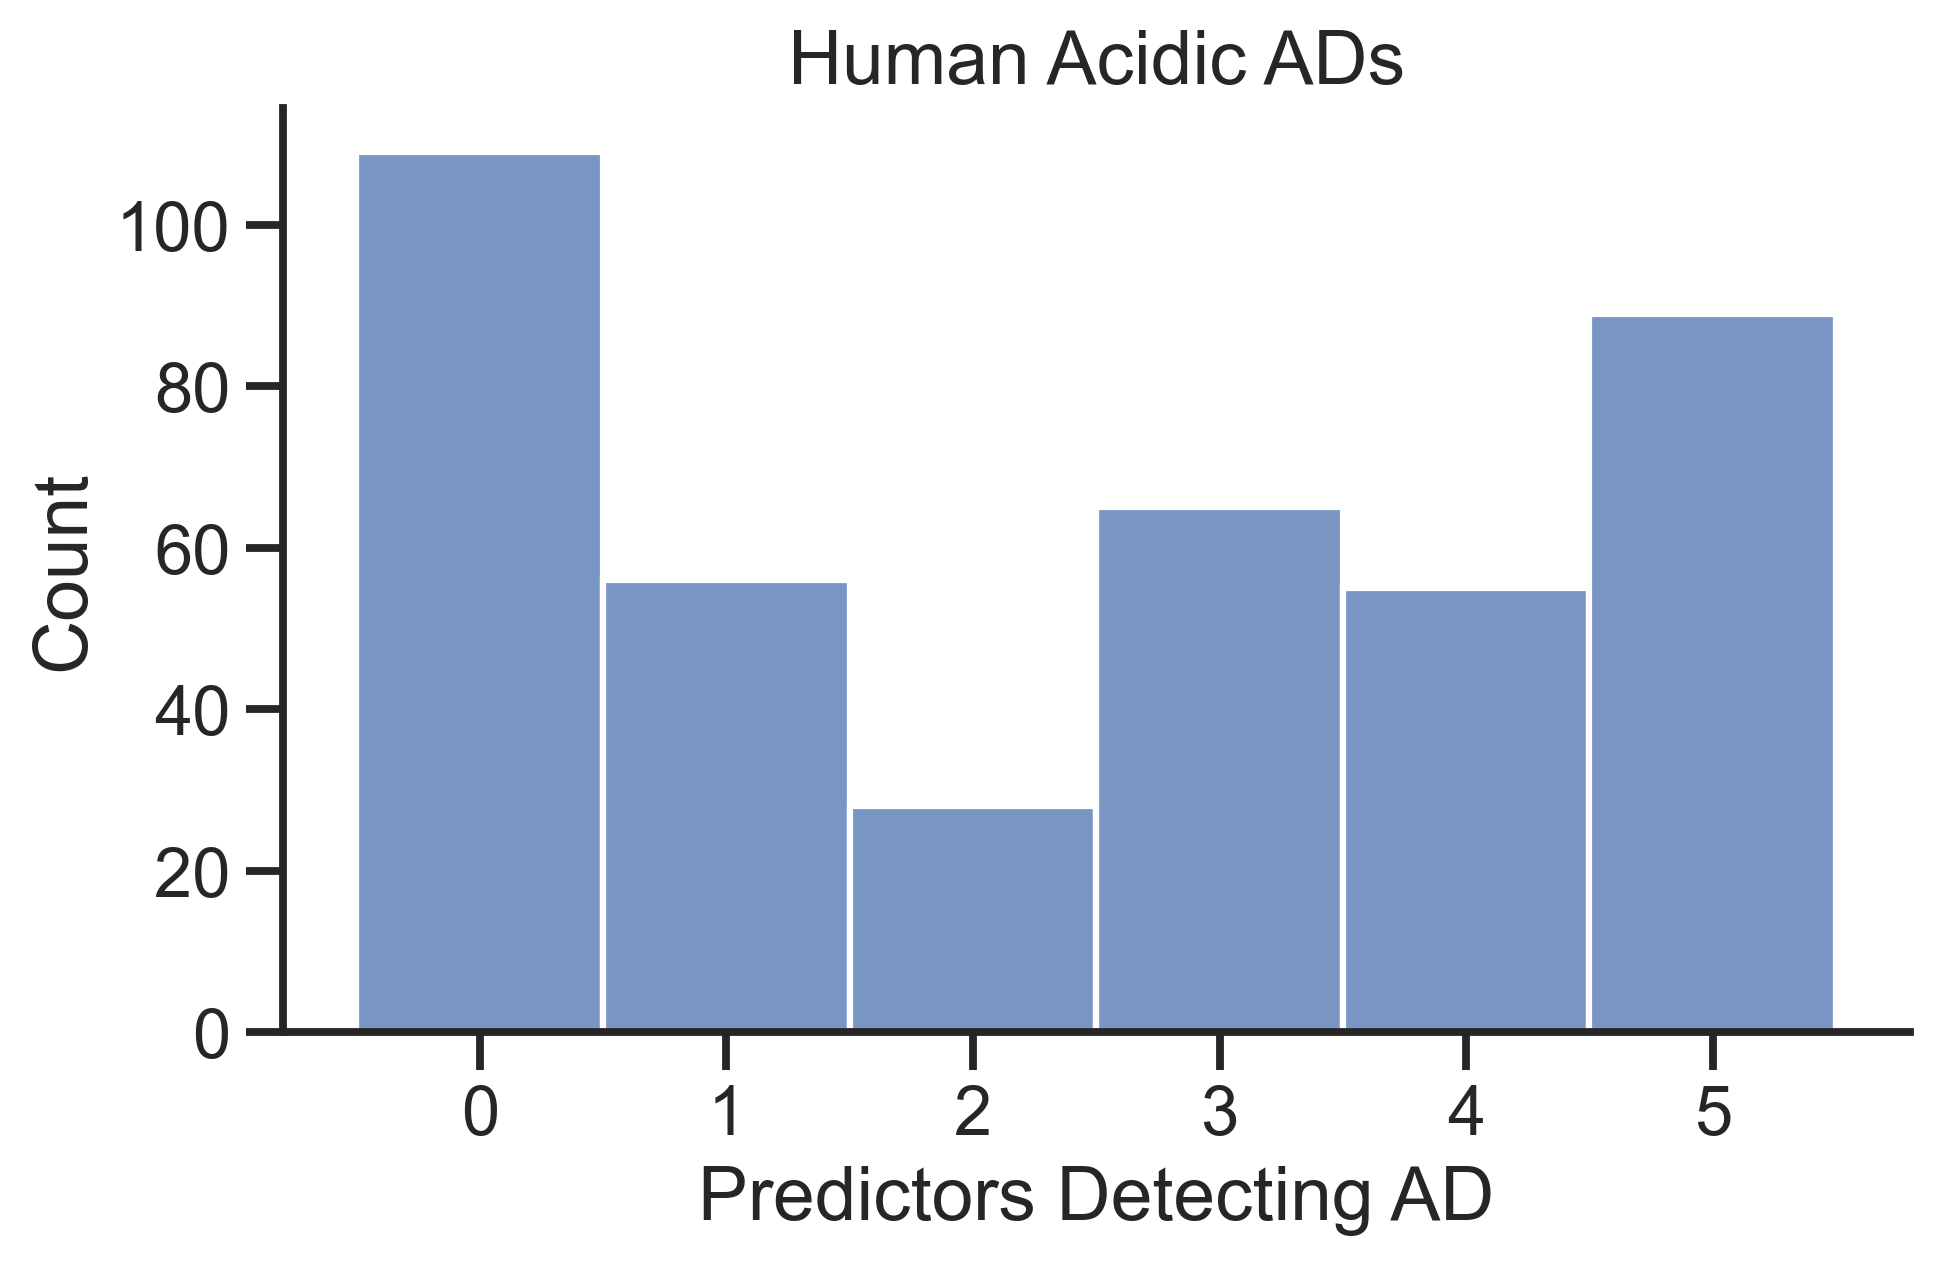

In [105]:
sns.set_context('talk')
sns.set_style('ticks')
plt.figure(figsize=(7, 4))
sns.histplot(acidic_known_ADs["pred_overlap_count"], bins = np.arange(-0.5, 6.5,1))
plt.xlabel("Predictors Detecting AD")
plt.title("Human Acidic ADs")
sns.despine()